### Visualizing synthetic data created using Vanderpol Oscillator dynamics

In [10]:
# imports
%matplotlib inline
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

import copy
import h5py
import torch
import scipy
import scipy.ndimage
from einops import rearrange

# local imports
from code_pack.plotting import plot_two_d_vector_field_from_data, raster_to_events
from code_pack.generate_vdp_data import generate_van_der_pol, generate_noisy_van_der_pol

We consider an Euler discretization of a Vanderpol oscillator with noisy transitions:

$z_{t+1,1} = z_{t,1} + \tau_1^{-1} \Delta z_{t,2} + \sigma \epsilon$\
$z_{t+1,2} = z_{t,2} + \tau_2^{-1} \Delta(\mu (1-z_{t,1})^2 z_{t,2} - z_{t,1}) + \sigma \epsilon$

and Poisson observations:

$y_{n,t} \sim \text{Poisson}(y_{n,t} \mid \Delta \exp(C_n^\top z_t + b_n))$

In [12]:
# loading data from ./data/vdp_noisy.h5
file_name = "data/poisson_obs.h5"

# dynamics parameters
data = h5py.File(file_name, 'r')
system_parameters = {}
system_parameters['mu'] = data['mu']
system_parameters['tau_1'] = data['tau_1']
system_parameters['tau_2'] = data['tau_2']
system_parameters['sigma'] = data['sigma']
system_parameters['scale'] = np.array(data['scale'])

### Visualizationing trajectories

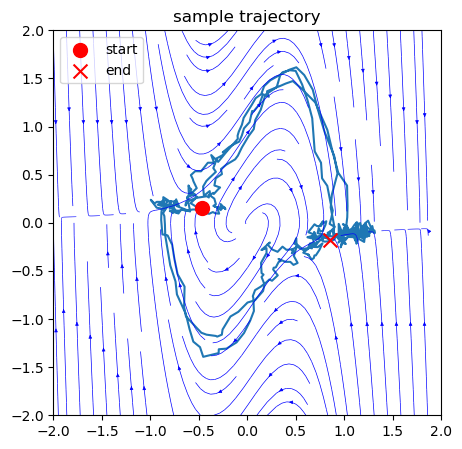

In [13]:
# plotting trajectories of the dataset
X = np.array(data['X'])
fig, ax = plt.subplots(1, 1, figsize=(5,5))
_ = ax.plot(X[0,:,0], X[0,:,1])
ax.scatter(X[0, 0, 0], X[0, 0, 1], marker='o', color='red', zorder=10, s=100, label='start')
ax.scatter(X[0, -1, 0], X[0, -1, 1], marker='x', color='red', zorder=10, s=100, label='end')

# system_parameters_copy = copy.deepcopy(system_parameters)
system_parameters['sigma'] = 0.0
dynamic_func = lambda inp : generate_noisy_van_der_pol(inp, np.array([0.0, 5e-3]), system_parameters)
axs_range = {'x_min':-1.5, 'x_max':1.5, 'y_min':-1.5, 'y_max':1.5}
plot_two_d_vector_field_from_data(dynamic_func, ax, axs_range)

ax.legend()
ax.set_title('sample trajectory');

### Effect of tuning function


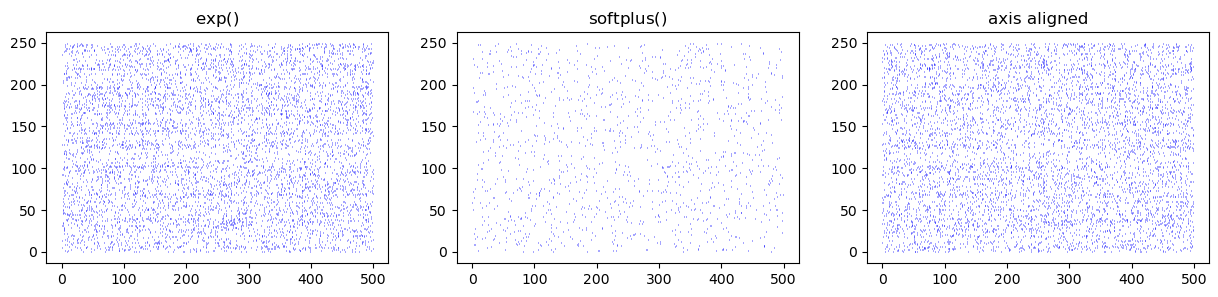

In [14]:
# showing the spike raster generated from noisy Vdp
fig, axs = plt.subplots(1, 3, figsize=(15, 3))
events = raster_to_events(np.array(data['Y'])[0,:,:])
events_softplus = raster_to_events(np.array(data['Y_softplus'])[0,:,:])
events_axis_aligned = raster_to_events(np.array(data['Y_axis'])[0,:,:])
axs[0].eventplot(events, linewidths=0.5, color='blue');
axs[1].eventplot(events_softplus, linewidths=0.5, color='blue');
axs[2].eventplot(events_axis_aligned, linewidths=0.5, color='blue');
axs[0].set_title(f'$\exp()$');
axs[1].set_title(f'softplus$()$');
axs[2].set_title(f'axis aligned');

### PCA
The first latent variable model that most people become familiar with is PCA.
Before performing PCA, we smooth the spikes with a Gaussian kernel

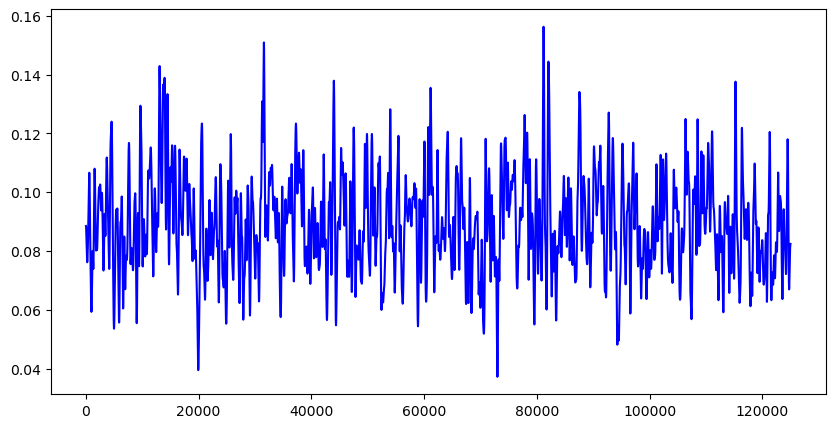

In [15]:
# smoothing data with a gaussian kernel
data_stacked = rearrange(np.array(data['Y']), 'trial time neurons -> (trial time) neurons')
data_smooth = scipy.ndimage.gaussian_filter1d(input = data_stacked, sigma=100.0, axis=0)
data_centered = data_smooth - np.mean(data_smooth, axis=0)

fig, ax = plt.subplots(1, 1, figsize =(10, 5))
ax.plot(data_smooth[:, 0], color='blue')

In [16]:
# PCA using SVD
u, s, vh = np.linalg.svd(data_centered, full_matrices=False)
u.shape, s.shape

((125000, 250), (250,))

In [17]:
norm_sv = s**2/np.sum(s**2)
top2sv = np.sum(norm_sv[:2])
print("Total observations explained by the first two principal components: {0:.3f}%".format(top2sv*100))

Total observations explained by the first two principal components: 21.781%


(125000, 2)


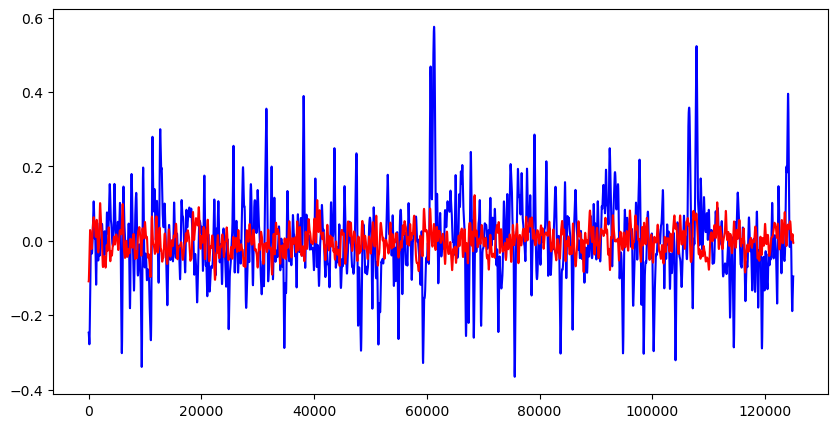

In [18]:
# visualizing top two PCs
top2u = u[:, :2]
top2s = s[:2]
top2reconstruction = top2u * top2s
print(top2reconstruction.shape)
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
ax.plot(top2reconstruction[:, 0], color='blue')
ax.plot(top2reconstruction[:, 1], color='red')

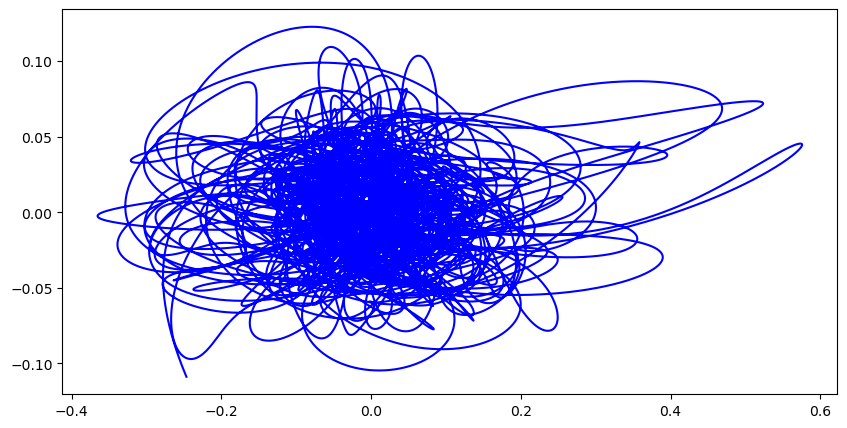

In [19]:
fig, ax = plt.subplots(1, 1, figsize =(10, 5))
ax.plot(top2reconstruction[:, 0], top2reconstruction[:, 1], color='blue')